# Project 2: Data Representations and Clustering

##### Group Member
Yifu Yuan, 804973353  
Zhiquan You, 205667859  
Wenxuan Wu, 705846929

### QUESTION 1: Report the dimensions of the TF-IDF matrix you obtain.

In [1]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))

In [2]:
import numpy as np

subset_texts = []
subset_labels = []
total_labels = dataset.target_names
str_to_int_labels = {}
for idx, label in enumerate(total_labels):
    str_to_int_labels[label] = idx
class0 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class1 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

class0_int = [str_to_int_labels[label] for label in class0]
class1_int = [str_to_int_labels[label] for label in class1]
for i in range(len(dataset.data)):
    if dataset.target[i] in class0_int:
        subset_texts.append(dataset.data[i])
        subset_labels.append(0)
    elif dataset.target[i] in class1_int:
        subset_texts.append(dataset.data[i])
        subset_labels.append(1)

subset_labels = np.array(subset_labels)
print(len(subset_texts))

7882


In [3]:
import re
import string
# Remove url, number and punctuations here
def clean(text):
    text = re.sub(r'https?://[^\s]+', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"[0-9]", "", texter)
    texter = re.compile('[%s]' % re.escape(string.punctuation)).sub('', texter)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [4]:
clean_subset_texts = []
for text in subset_texts:
    clean_subset_texts.append(clean(text))

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(min_df=3, stop_words='english')
vectorizer.fit(clean_subset_texts)
vocab = vectorizer.get_feature_names_out()

pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),
                 ('tfid', TfidfTransformer())]).fit(clean_subset_texts)
tf_idf_matrix = pipe.transform(clean_subset_texts)

In [7]:
print(tf_idf_matrix.shape)

(7882, 19033)


As we can see, the shapes of the TF-IDF matrix is (7882, 19033).

### QUESTION 2: Report the contingency table of your clustering result.

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(tf_idf_matrix)
kmeans_pred = kmeans.predict(tf_idf_matrix)

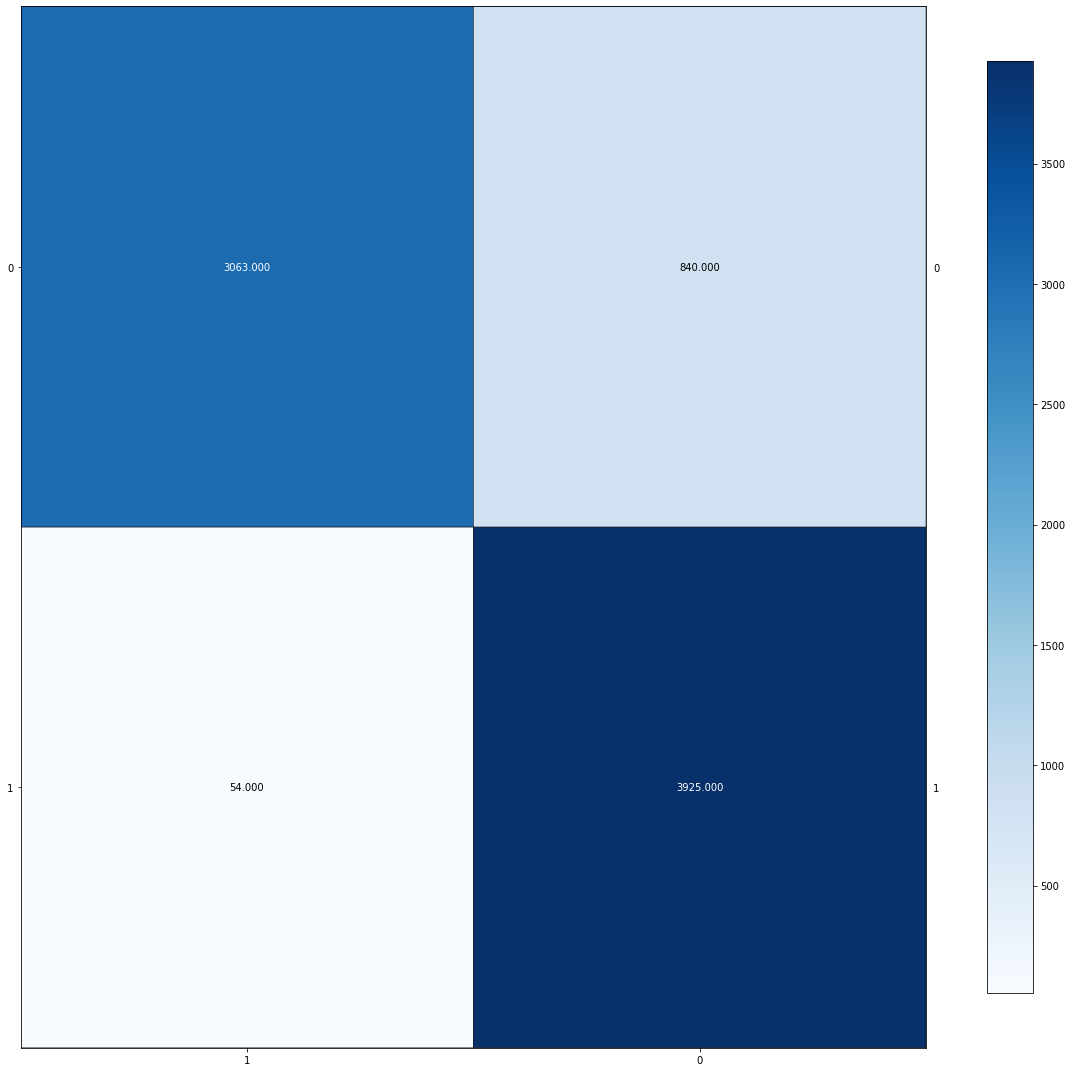

In [9]:
from plotmat import plot_mat
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix

labels = dataset.target
#kmeans_contingency_matrix = contingency_matrix(subset_labels, kmeans_pred)
#print(kmeans_contingency_matrix)
cm = confusion_matrix(subset_labels, kmeans_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

The contingency matrix is reported as above. In a sense the matrix has to be square-shaped, because we would want the cluster number to match true class numbers. However, it is also feasible to have non-square-shaped contingency matrix.

### QUESTION 3: Report the 5 clustering measures explained in the introduction for Kmeans clustering.

In [10]:
from sklearn import metrics

def report_five_scores(true_label, pred_label, verbose=False):
    homogeneity_score = metrics.homogeneity_score(true_label, pred_label)
    completeness_score = metrics.completeness_score(true_label, pred_label)
    v_measure_score = metrics.v_measure_score(true_label, pred_label)
    adjusted_rand_score = metrics.adjusted_rand_score(true_label, pred_label)
    adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(true_label, pred_label)
    
    if verbose:
        print("homogeneity score is {}".format(metrics.homogeneity_score(true_label, pred_label)))
        print("completeness score is {}".format(metrics.completeness_score(true_label, pred_label)))
        print("v measure score is {}".format(metrics.v_measure_score(true_label, pred_label)))
        print("adjusted rand score is {}".format(metrics.adjusted_rand_score(true_label, pred_label)))
        print("adjusted mutual info score is {}".format(metrics.adjusted_mutual_info_score(true_label, pred_label)))
    
    return homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

report_five_scores(subset_labels, kmeans_pred, verbose=True)

homogeneity score is 0.5439040986349226
completeness score is 0.5617123146377255
v measure score is 0.5526647877464653
adjusted rand score is 0.5977166977328249
adjusted mutual info score is 0.5526231738962077


(0.5439040986349226,
 0.5617123146377255,
 0.5526647877464653,
 0.5977166977328249,
 0.5526231738962077)

### QUESTION 4: Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

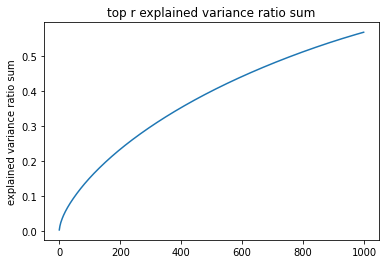

In [11]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=1000)
svd.fit(tf_idf_matrix)

top_ev_sum = [svd.explained_variance_ratio_[0]]
for i in range(1, len(svd.explained_variance_ratio_)):
    top_ev_sum.append(svd.explained_variance_ratio_[i] + top_ev_sum[-1])
    
plt.plot(top_ev_sum)
plt.title('top r explained variance ratio sum')
plt.ylabel('explained variance ratio sum')
plt.show()

We can see that as the number of components r increases, the explained variance ratio increases as well.

### QUESTION 5: Report a good choice of r for SVD and NMF respectively.

In [12]:
from sklearn.decomposition import NMF

svd_scores = []
nmf_scores = []
r_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
for r in r_list:
    svd_matrix = TruncatedSVD(n_components=r).fit_transform(tf_idf_matrix)
    nmf_matrix = NMF(n_components=r, tol=0.05, max_iter=50).fit_transform(tf_idf_matrix)
    kmeans_svd = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(svd_matrix)
    kmeans_nmf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(nmf_matrix)
    kmeans_svd_pred = kmeans_svd.predict(svd_matrix)
    kmeans_nmf_pred = kmeans_nmf.predict(nmf_matrix)
    svd_scores.append(report_five_scores(subset_labels, kmeans_svd_pred))
    nmf_scores.append(report_five_scores(subset_labels, kmeans_nmf_pred))
    
svd_scores = np.array(svd_scores)
nmf_scores = np.array(nmf_scores)

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None'

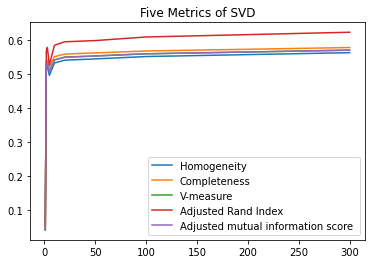

In [13]:
plt.plot(r_list, svd_scores[:, 0], label="Homogeneity")
plt.plot(r_list, svd_scores[:, 1], label="Completeness")
plt.plot(r_list, svd_scores[:, 2], label="V-measure")
plt.plot(r_list, svd_scores[:, 3], label="Adjusted Rand Index")
plt.plot(r_list, svd_scores[:, 4], label="Adjusted mutual information score ")
plt.legend()
plt.title("Five Metrics of SVD")
plt.show()

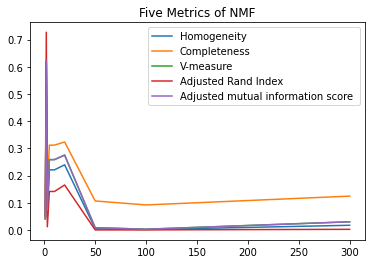

In [14]:
plt.plot(r_list, nmf_scores[:, 0], label="Homogeneity")
plt.plot(r_list, nmf_scores[:, 1], label="Completeness")
plt.plot(r_list, nmf_scores[:, 2], label="V-measure")
plt.plot(r_list, nmf_scores[:, 3], label="Adjusted Rand Index")
plt.plot(r_list, nmf_scores[:, 4], label="Adjusted mutual information score ")
plt.legend()
plt.title("Five Metrics of NMF")
plt.show()

In [ ]:
best_hm_index = list(nmf_scores[:, 0]).index(max(nmf_scores[:, 0]))
best_com_index = list(nmf_scores[:, 1]).index(max(nmf_scores[:, 1]))
best_vm_index = list(nmf_scores[:, 2]).index(max(nmf_scores[:, 2]))
best_ari_index = list(nmf_scores[:, 3]).index(max(nmf_scores[:, 3]))
best_ami_index = list(nmf_scores[:, 4]).index(max(nmf_scores[:, 4]))

print(best_hm_index)
print(best_com_index)
print(best_vm_index)
print(best_ari_index)
print(best_ami_index)

print("best r for nmf is: ", r_list[best_hm_index])

1
1
1
1
1
best r for nmf is:  2


### QUESTION 6: How do you explain the non-monotonic behavior of the measures as r increases?

From both charts, we can observe the non-monotonic behaviors in the measures as the number of components increases. We can see that all the five measures initially increase or to the peak, then falls down and stays flat. Supposedly, the more the components, the more information would be preserved, and the better the clusters would be formed. However, it is not the case here with k-means clusters. The reason behind this might be that k-means clustering algorithms suffer from the curve of dimensionalities, as when the number of components(dimensions) increases, the data becomes more sparse in each dimension. And this causes the Euclidean distance to be no longer a good measure for forming clusters. In higher dimensions, all the distances between points will just be approaching 1. We can also observe that NMF chart changed drastically as compared to SVD chart. This might be due to the fact that NMF only allows positive vectors while SVD do not have this kind of restriction. Therefore, SVD has more information to feed in as the number of components increase till no more new information.

### QUESTION 7: Are these measures on average better than those computed in Question 3?

From svd chart we can see that the 5 measures increased a little as compared to those computed in Q3, with the values over 0.6, as the number of dimensionalities increase; however, from nmf chart the measures peaked at the first few components and then drops tremendously, the average measures are worse than those computed in Q3, with the values drop down to between 0.1 and 0.2, as the number of dimensions increase.

### QUESTION 8: Visualize the clustering results

In [ ]:
svd_matrix = TruncatedSVD(n_components=100).fit_transform(tf_idf_matrix)
nmf_matrix = NMF(n_components=20).fit_transform(tf_idf_matrix)

svd_matrix_2d = TruncatedSVD(n_components=2).fit_transform(svd_matrix)
nmf_matrix_2d = TruncatedSVD(n_components=2).fit_transform(nmf_matrix)

kmeans_svd = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(svd_matrix)
kmeans_nmf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30).fit(nmf_matrix)
kmeans_svd_pred = kmeans_svd.predict(svd_matrix)
kmeans_nmf_pred = kmeans_nmf.predict(nmf_matrix)

c:\users\yivyu\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


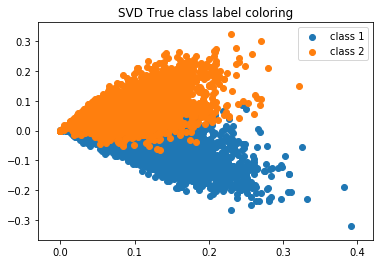

In [ ]:
svd_matrix_true_class0 = svd_matrix_2d[np.where(subset_labels==0)]
svd_matrix_true_class1 = svd_matrix_2d[np.where(subset_labels==1)]
plt.scatter(svd_matrix_true_class0[:, 0], svd_matrix_true_class0[:, 1], label="class 1")
plt.scatter(svd_matrix_true_class1[:, 0], svd_matrix_true_class1[:, 1], label="class 2")
plt.legend()
plt.title("SVD True class label coloring")
plt.show()

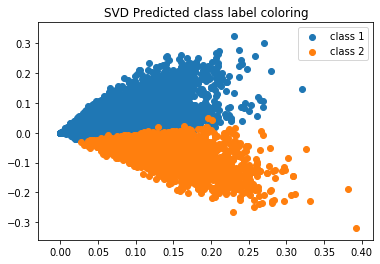

In [ ]:
svd_matrix_pred_class0 = svd_matrix_2d[np.where(kmeans_svd_pred==0)]
svd_matrix_pred_class1 = svd_matrix_2d[np.where(kmeans_svd_pred==1)]
plt.scatter(svd_matrix_pred_class0[:, 0], svd_matrix_pred_class0[:, 1], label="class 1")
plt.scatter(svd_matrix_pred_class1[:, 0], svd_matrix_pred_class1[:, 1], label="class 2")
plt.legend()
plt.title("SVD Predicted class label coloring")
plt.show()

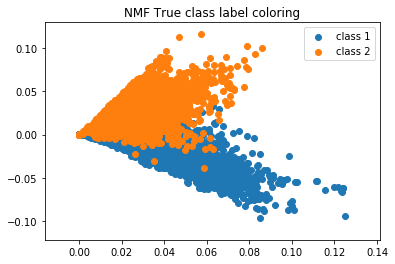

In [ ]:
nmf_matrix_true_class0 = nmf_matrix_2d[np.where(subset_labels==0)]
nmf_matrix_true_class1 = nmf_matrix_2d[np.where(subset_labels==1)]
plt.scatter(nmf_matrix_true_class0[:, 0], nmf_matrix_true_class0[:, 1], label="class 1")
plt.scatter(nmf_matrix_true_class1[:, 0], nmf_matrix_true_class1[:, 1], label="class 2")
plt.legend()
plt.title("NMF True class label coloring")
plt.show()

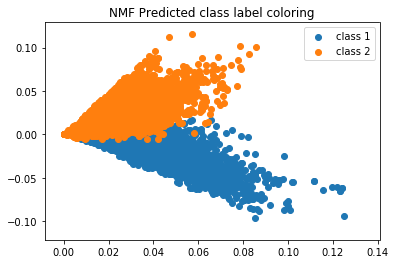

In [ ]:
nmf_matrix_pred_class0 = nmf_matrix_2d[np.where(kmeans_nmf_pred==0)]
nmf_matrix_pred_class1 = nmf_matrix_2d[np.where(kmeans_nmf_pred==1)]
plt.scatter(nmf_matrix_pred_class0[:, 0], nmf_matrix_pred_class0[:, 1], label="class 1")
plt.scatter(nmf_matrix_pred_class1[:, 0], nmf_matrix_pred_class1[:, 1], label="class 2")
plt.legend()
plt.title("NMF Predicted class label coloring")
plt.show()

### QUESTION 9: What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

We can observe from the graphes that even though there are clusters forming, these clusters are not rounded (isotropic) as k-means implicitly assumed. Some of the data points in two clusters are very close to each other and even overlaps in two clusters(such as in the svd pred label graph). This makes the decision boundary vague.

### QUESTION 10: Visualize the contingency matrix and report the five clustering metrics.

In [ ]:
clean_texts = []
for text in dataset.data:
    clean_texts.append(clean(text))

In [ ]:
vectorizer = CountVectorizer(min_df=3, stop_words='english')
vectorizer.fit(clean_texts)
vocab = vectorizer.get_feature_names_out()

pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),
                 ('tfid', TfidfTransformer())]).fit(clean_texts)
total_tf_idf_matrix = pipe.transform(clean_texts)

svd = TruncatedSVD(n_components=100)
svd_total_matrix = svd.fit_transform(total_tf_idf_matrix)

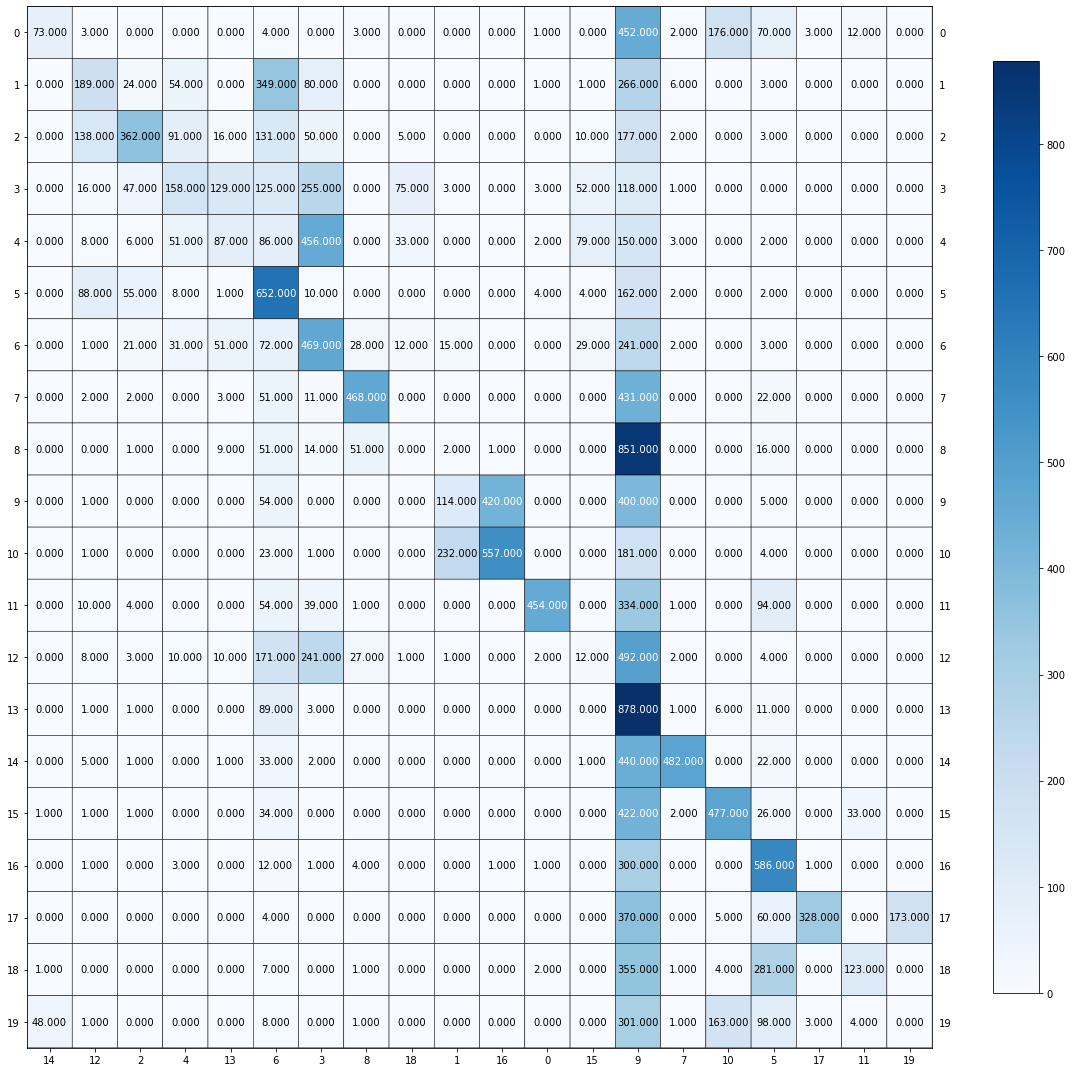

In [ ]:
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30).fit(svd_total_matrix)
kmeans_pred = kmeans.predict(svd_total_matrix)

labels = dataset.target
cm = confusion_matrix(labels, kmeans_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))


In [ ]:
report_five_scores(labels, kmeans_pred, verbose=True)

homogeneity score is 0.3514554044754759
completeness score is 0.460765624632408
v measure score is 0.39875492795710077
adjusted rand score is 0.09736766333193723
adjusted mutual info score is 0.39653467075136906


(0.3514554044754759,
 0.460765624632408,
 0.39875492795710077,
 0.09736766333193723,
 0.39653467075136906)

### Question 11

In [ ]:
import umap.umap_ as umap
reducer_cos = umap.UMAP(n_components=100, metric="cosine")
reducer_euc = umap.UMAP(n_components=100, metric="euclidean")

In [ ]:
umap_matrix_cos = reducer_cos.fit_transform(total_tf_idf_matrix)
umap_matrix_euc = reducer_euc.fit_transform(total_tf_idf_matrix)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
umap_matrix_euc.shape
type(umap_matrix_euc[0])
print(type(umap_matrix_cos) == type(np.zeros((2,100))))
type(np.zeros((2,100)))
type(np.array(umap_matrix_cos))

True


numpy.ndarray

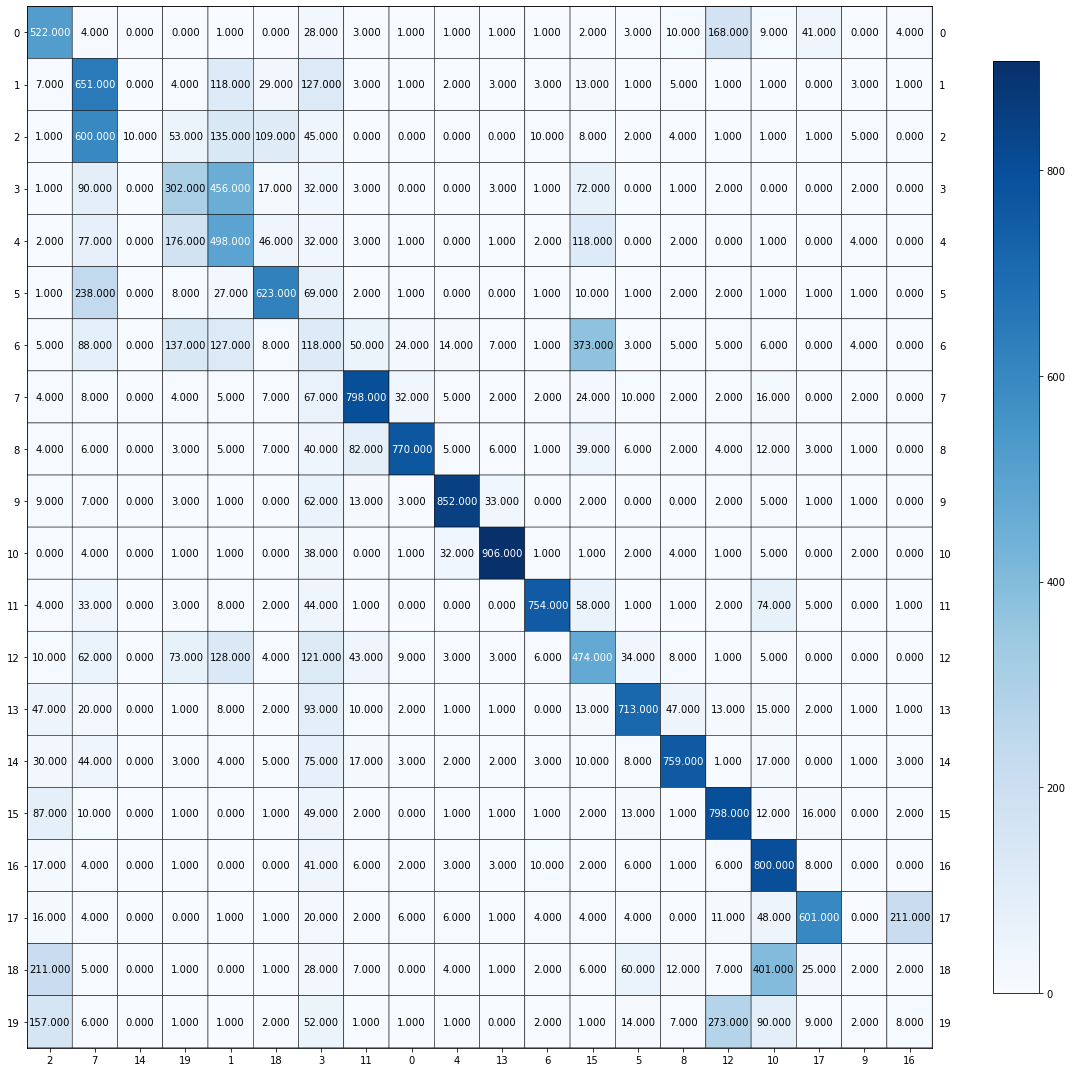

homogeneity score is 0.565559606915854
completeness score is 0.5963925949402894
v measure score is 0.580567016479935
adjusted rand score is 0.4268614959839434
adjusted mutual info score is 0.5791633798760232


In [ ]:
# Plot and scores for cosine
kmeans_cos = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30).fit(umap_matrix_cos)
kmeans_pred_cos = kmeans_cos.predict(umap_matrix_cos)

cm = confusion_matrix(labels, kmeans_pred_cos)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

_ = report_five_scores(labels, kmeans_pred_cos, verbose=True)

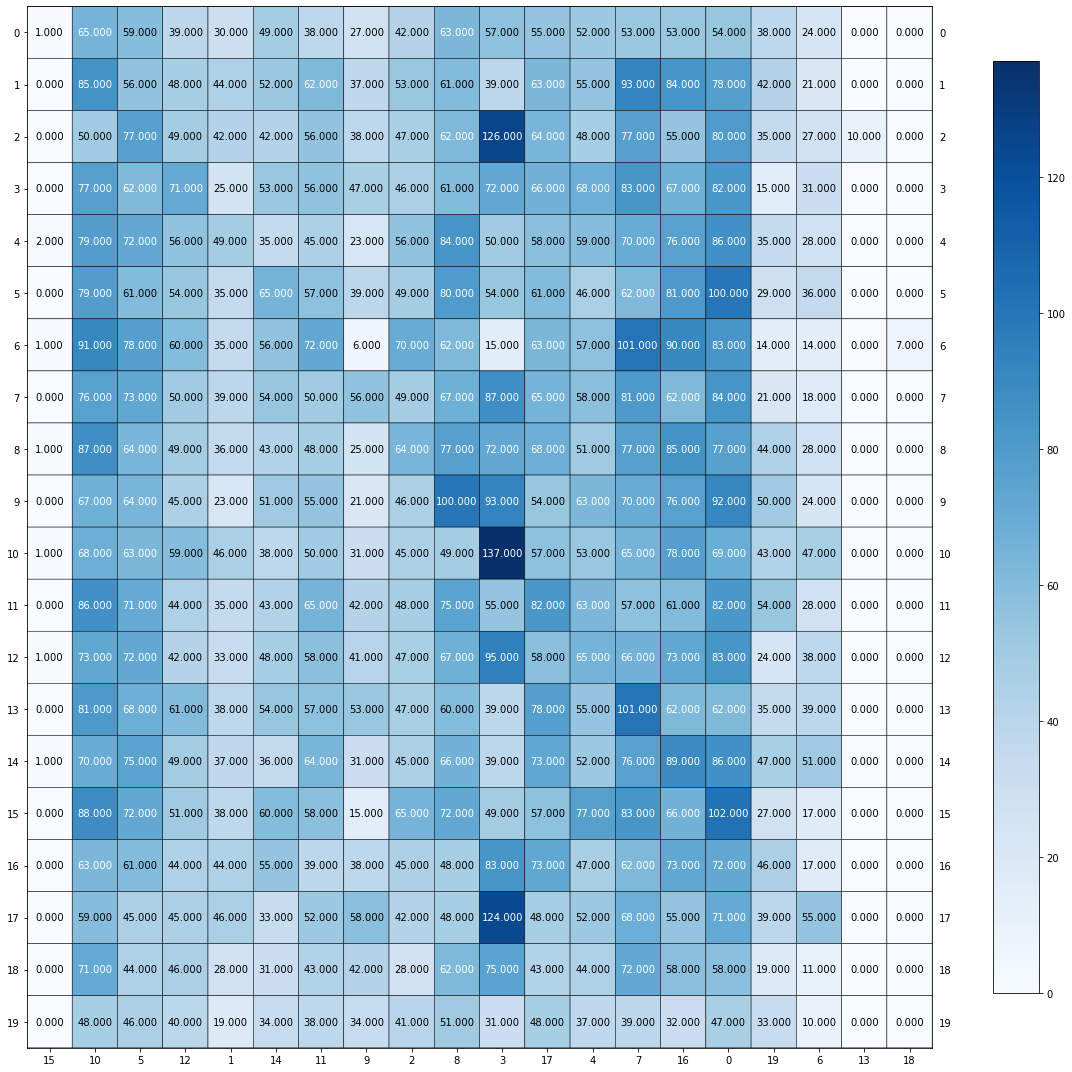

homogeneity score is 0.009223870650658035
completeness score is 0.009841890219234995
v measure score is 0.009522863835300937
adjusted rand score is 0.0017821870998343235
adjusted mutual info score is 0.006242254863611114


In [ ]:
# Plot and scores for euclidean
kmeans_euc = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30).fit(umap_matrix_euc)
kmeans_pred_euc = kmeans_euc.predict(umap_matrix_euc)

cm = confusion_matrix(labels, kmeans_pred_euc)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

_ = report_five_scores(labels, kmeans_pred_euc, verbose=True)

### QUESTION 12: Analyze the contingency matrix.

From the contingency matrix of both UMAPs with different distance metrics as well as the five measurement metrics, we can see that UMAP with cosine distance metric perform way better as compared to UMAP with Euclidean distance metrics. The reason behind it is that cosine distance is not affected by the magnitude of the vectors as well as the dimensionalities. In higher dimensions, the data becomes sparse and the Euclidean distance does not perform well under this condition; the distance between each data points would just be very similar to each other. And that makes UMAP form a lot of clusters which indeed does not make sense.

### QUESTION 13: So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse representation, PCA, NMF, UMAP). Compare and contrast the results from the previous sections, and discuss which approach is best for the K-Means clustering task on the 20-class text data.

From Q10's results, we can see that K-means clustering with SVD(or PCA) perform very badly when the number of categories are 20, with each of the five measures near 0.4. From Q5's result, we can see that NMF's performance metrics decrease tremendouly as the number of dimensions increases. Even though from Q3's results we can observe that K-means with sparse representation has each metrics near 0.55, it just has 2 classes. Undoutedly, when the number of classes increase, the performance will decrease. Lastly, we can observe from Q11, UMAP with cosine distance perform very well with K-Means clustering with 20-class text data, with the metrics also around 0.55. Therefore, we think K-Means clustering with UMAP is the best for the task on the 20-class text data.

### QUESTION 14: Report the five clustering evaluation metrics for Agglomerative Clustering ("ward" and "single")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
ward_pred = AgglomerativeClustering(n_clusters=20, linkage='ward').fit_predict(umap_matrix_cos)
single_pred = AgglomerativeClustering(n_clusters=20, linkage='single').fit_predict(umap_matrix_cos)

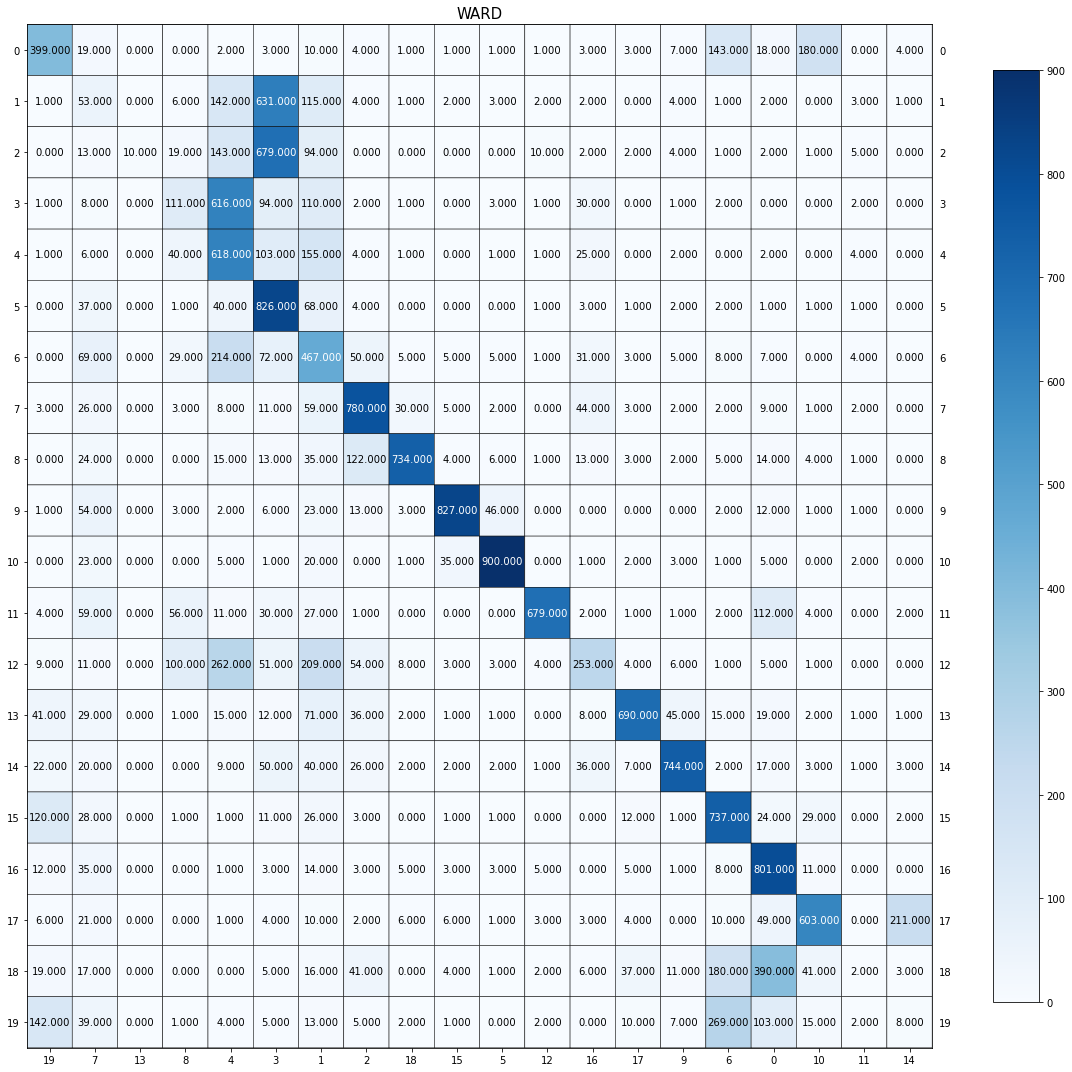

homogeneity score is 0.5352512786660772
completeness score is 0.5817385610815914
v measure score is 0.5575275577056754
adjusted rand score is 0.3837101150046569
adjusted mutual info score is 0.5560240578608866


In [ ]:
# Plot and scores for ward
cm = confusion_matrix(labels, ward_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], title='WARD', xticklabels=cols, yticklabels=rows, size=(15,15))

_ = report_five_scores(labels, ward_pred, verbose=True)

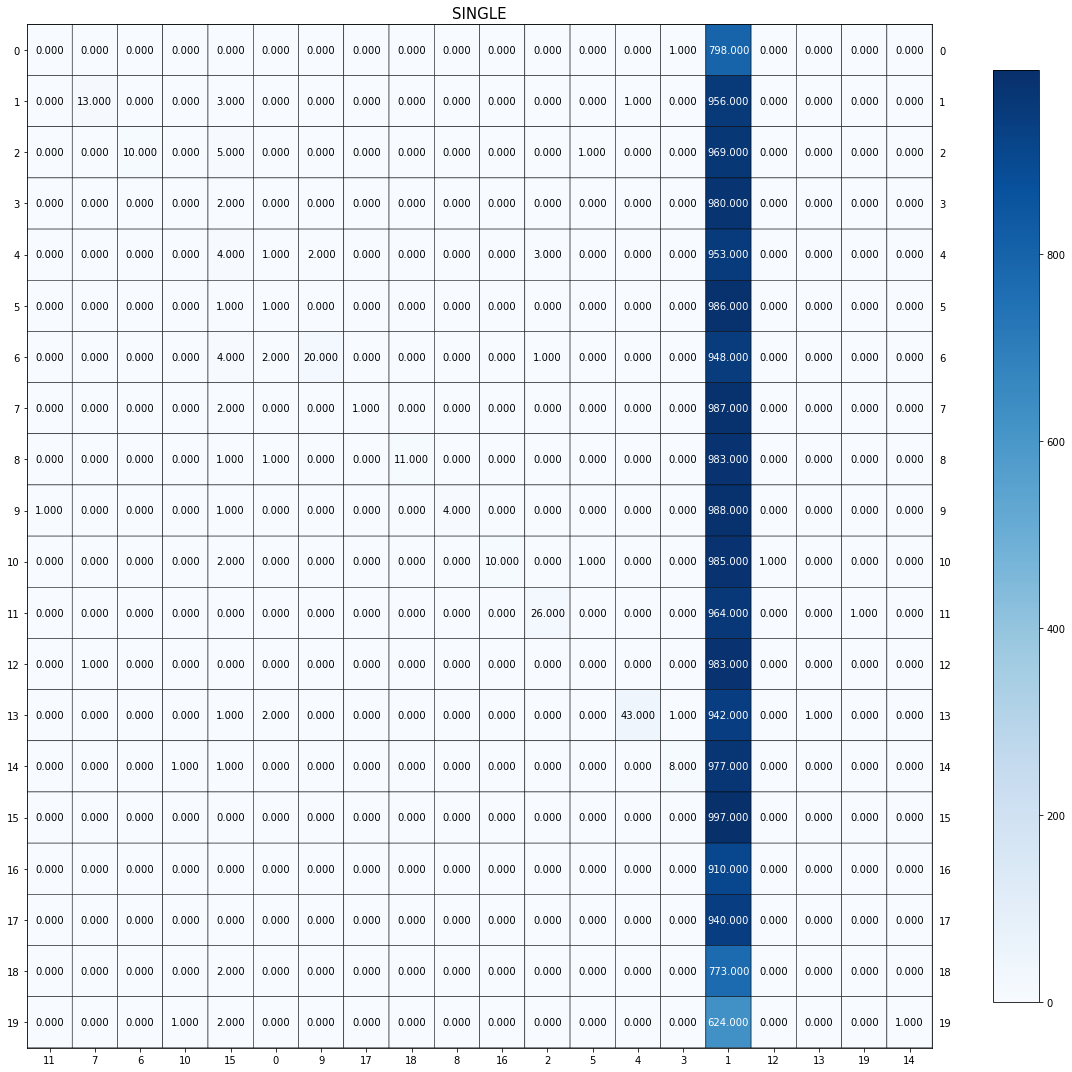

homogeneity score is 0.008459592210408469
completeness score is 0.29741871601463976
v measure score is 0.01645125519247983
adjusted rand score is -2.319643732808477e-05
adjusted mutual info score is 0.011784761898616323


In [ ]:
# Plot and scores for single
cm = confusion_matrix(labels, single_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], title='SINGLE', xticklabels=cols, yticklabels=rows, size=(15,15))

_ = report_five_scores(labels, single_pred, verbose=True)

### QUESTION 15: Experiment on DBSCAN and HDBSCAN

In [ ]:
import hdbscan
from sklearn.cluster import DBSCAN

db_scores = []
hdb_scores = []
hyper_param = []

# range_eps = [0.01,0.05, 0.1, 0.5, 1, 5, 10, 50,100]
range_sample_size = [5,30,60,100,200,500]

# for ep in range_eps:
for m in range_sample_size:
    print("sample size: ", m)
    hyper_param.append(m)
    db_pred = DBSCAN(eps=0.5, min_samples=m).fit_predict(umap_matrix_cos)
    db_scores.append(report_five_scores(labels, db_pred))

    clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=m, cluster_selection_epsilon = 0.5)
    clusterer.fit(umap_matrix_cos)
    hdb_pred = clusterer.labels_
    hdb_scores.append(report_five_scores(labels, hdb_pred))

# clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
# clusterer.fit(umap_matrix_cos)

# db_pred = DBSCAN(min_samples=100).fit_predict(umap_matrix_cos)
# hdb_pred = clusterer.labels_


sample size:  5
sample size:  30
sample size:  60
sample size:  100
sample size:  200
sample size:  500


In [ ]:

#DBSCAN has two hyperparameters like eps & min_samples.

db_scores_list = np.array(db_scores)
hdb_scores_list = np.array(hdb_scores)

db_homo = db_scores_list[:,0]
db_cm = db_scores_list[:,1]
db_vm = db_scores_list[:,2]
db_ar = db_scores_list[:,3]
db_ami = db_scores_list[:,4]

hdb_homo = hdb_scores_list[:,0]
hdb_cm = hdb_scores_list[:,1]
hdb_vm = hdb_scores_list[:,2]
hdb_ar = hdb_scores_list[:,3]
hdb_ami = hdb_scores_list[:,4]

db_avg_metrics = []
hdb_avg_metrics = []

for measure in zip(db_homo, db_cm, db_vm, db_ar, db_ami):
    db_avg_metrics.append(sum(measure) / 5)

for measure in zip(hdb_homo, hdb_cm, hdb_vm, hdb_ar, hdb_ami):
    hdb_avg_metrics.append(sum(measure) / 5)

db_best_param = hyper_param[db_avg_metrics.index(max(db_avg_metrics))]
hdb_best_param = hyper_param[hdb_avg_metrics.index(max(hdb_avg_metrics))]

    
print('The best sample size for DBSCAN is: ', db_best_param)
print('The best sample size for HDBSCAN is: ', hdb_best_param)

print('----------------------------------------------------------------------')

print('DBSCAN Homogeneity: ', db_homo[db_avg_metrics.index(max(db_avg_metrics))])
print('DBSCAN Completeness: ', db_cm[db_avg_metrics.index(max(db_avg_metrics))])
print('DBSCAN V-measure: ', db_vm[db_avg_metrics.index(max(db_avg_metrics))])
print('DBSCAN Adjusted Random Index: ', db_ar[db_avg_metrics.index(max(db_avg_metrics))])
print('DBSCAN Adjusted Mutual Information Score: ', db_ami[db_avg_metrics.index(max(db_avg_metrics))])

print('----------------------------------------------------------------------')

print('HDBSCAN Homogeneity: ', hdb_homo[hdb_avg_metrics.index(max(hdb_avg_metrics))])
print('HDBSCAN Completeness: ', hdb_cm[hdb_avg_metrics.index(max(hdb_avg_metrics))])
print('HDBSCAN V-measure: ', hdb_vm[hdb_avg_metrics.index(max(hdb_avg_metrics))])
print('HDBSCAN Adjusted Random Index: ', hdb_ar[hdb_avg_metrics.index(max(hdb_avg_metrics))])
print('HDBSCAN Adjusted Mutual Information Score: ', hdb_ami[hdb_avg_metrics.index(max(hdb_avg_metrics))])




# print(np.argmax(hdb_homo))
# print(np.argmax(hdb_cm))
# print(np.argmax(hdb_vm))
# print(np.argmax(hdb_ar))
# print(np.argmax(hdb_ami))




The best sample size for DBSCAN is:  100
The best sample size for HDBSCAN is:  60
----------------------------------------------------------------------
DBSCAN Homogeneity:  0.48565316708574163
DBSCAN Completeness:  0.5540970289969699
DBSCAN V-measure:  0.5176223635619719
DBSCAN Adjusted Random Index:  0.26045028644995655
DBSCAN Adjusted Mutual Information Score:  0.5158623698713587
----------------------------------------------------------------------
HDBSCAN Homogeneity:  0.40782983691293384
HDBSCAN Completeness:  0.6212396028090552
HDBSCAN V-measure:  0.49240612172084314
HDBSCAN Adjusted Random Index:  0.21409190166907485
HDBSCAN Adjusted Mutual Information Score:  0.49147007566739925


For hyperparameter tuning, we used cluster selection epsilon and minimum samples as changing parameters for testing purposes. We can see that from the 5 measures of both models, the performance is very close; this is expected because HDBSCAN is just an extend of DBSCAN, making it a hierarchical clustering algorithm. The advantage of HDBSCAN over DBSCAN is its ability to perform well with high density clustering. Therefore, in the absence of the high density clustering, the two models' performance don't vary much.

##### QUESTION 16: Contingency matrix

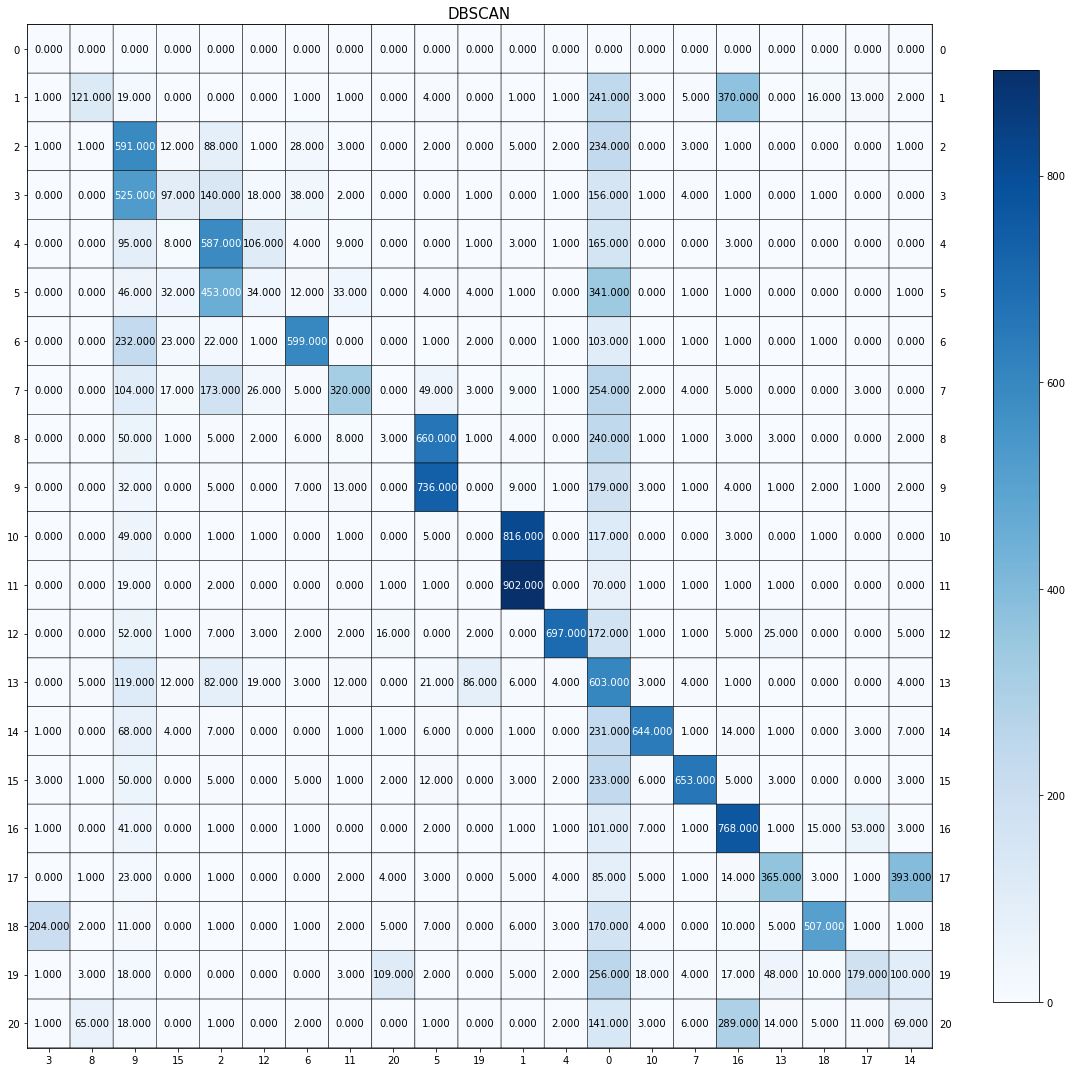

In [ ]:
db_pred = DBSCAN(eps=0.5, min_samples=db_best_param).fit_predict(umap_matrix_cos)
cm = confusion_matrix(labels, db_pred)
rows, cols = linear_sum_assignment(cm,maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'DBSCAN', size=(15,15))


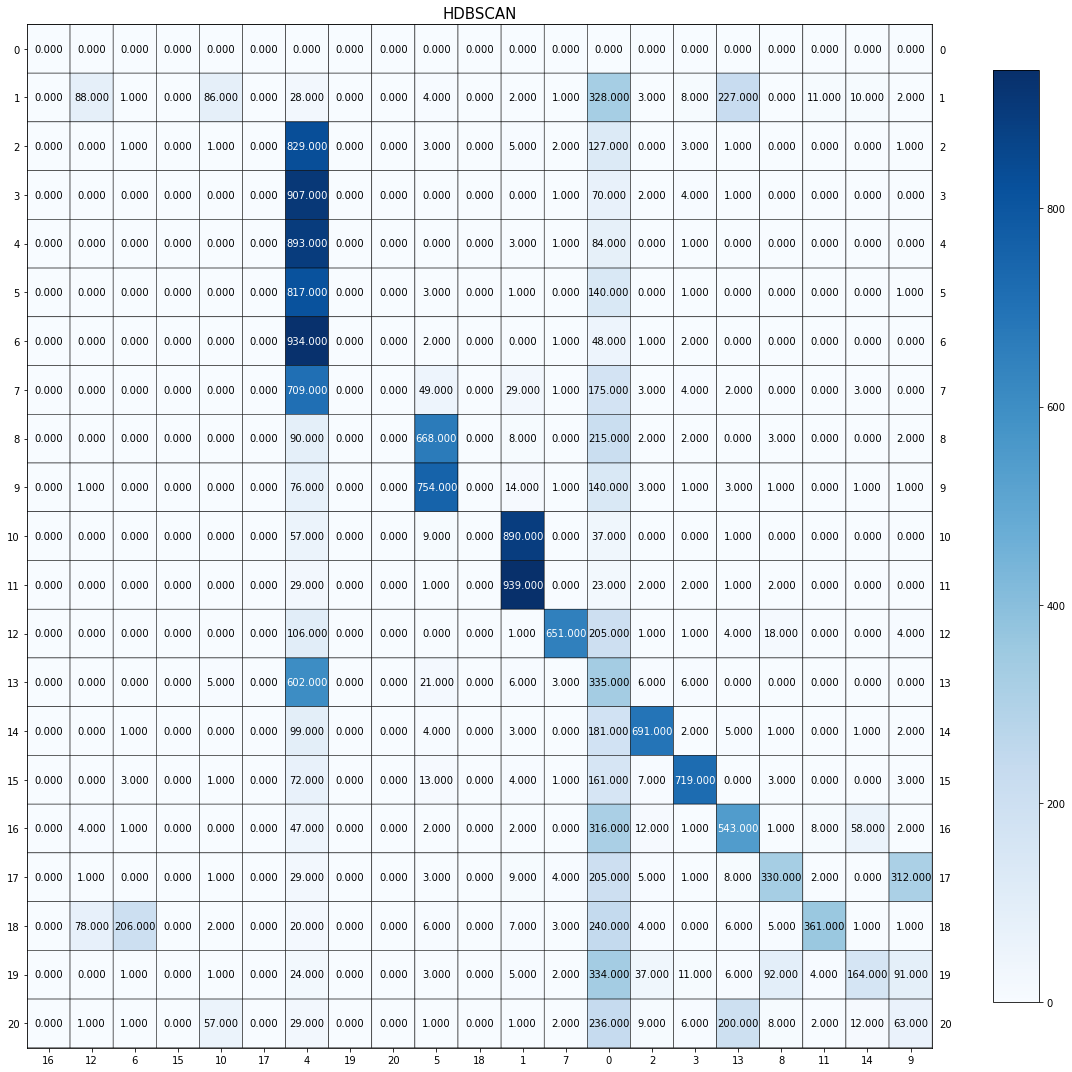

In [ ]:

hdb_pred = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=hdb_best_param).fit_predict(umap_matrix_cos)
cm = confusion_matrix(labels, hdb_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'HDBSCAN', size=(15,15))

##### How many clusters are given by the model? What does “-1” mean for the clustering labels?

As we can observe from the contingency matrix, DBSCAN has 11 clusters while HDBSCAN has 12 clusters. "-1" means that in clustering there are outliers or noices that haven't been classified into any of the class labels.

### QUESTION 17: Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? Follow the table below.

In [ ]:
def printResults(svd_score, nmf_score, umap_score, autoencoder_score, hyper_param, cluster, withDimReduc, wo_dr_score, grid_HDBSCAN):

    if withDimReduc == True:
        svd_score = np.array(svd_score)
        nmf_score= np.array(nmf_score)
        umap_score= np.array(umap_score)
        autoencoder_score = np.array(autoencoder_score)

        svd_avg_metrics = []
        nmf_avg_metrics = []
        umap_avg_metrics = []
        autoencoder_avg_metrics = []

        if len(svd_score) > 0:
            svd_homo = svd_score[:,0]
            svd_cm = svd_score[:,1]
            svd_vm = svd_score[:,2]
            svd_ar = svd_score[:,3]
            svd_ami = svd_score[:,4]

            for measure in zip(svd_homo, svd_cm, svd_vm, svd_ar, svd_ami):
                svd_avg_metrics.append(sum(measure) / 5)

            if grid_HDBSCAN == False:
                print('SVD Component: ', hyper_param[svd_avg_metrics.index(max(svd_avg_metrics))][0], cluster, ': ', hyper_param[svd_avg_metrics.index(max(svd_avg_metrics))][1])
                print("SVD Best Homogeneity: ", svd_homo[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best Completeness: ", svd_cm[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best V measure: ", svd_vm[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best Adjusted Rand Index: ", svd_ar[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best Adjusted Mutual Info Score: ", svd_ami[svd_avg_metrics.index(max(svd_avg_metrics))])

                print("---------------------------------------------------------------------------------------------------------")

            else:
                print(cluster, 'SVD Component 50, Best min cluster size is: ', hyper_param[svd_avg_metrics.index(max(svd_avg_metrics))][0] , ' Best min sample size is: ', hyper_param[svd_avg_metrics.index(max(svd_avg_metrics))][1])
                print("SVD Best Homogeneity: ", svd_homo[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best Completeness: ", svd_cm[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best V measure: ", svd_vm[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best Adjusted Rand Index: ", svd_ar[svd_avg_metrics.index(max(svd_avg_metrics))])
                print("SVD Best Adjusted Mutual Info Score: ", svd_ami[svd_avg_metrics.index(max(svd_avg_metrics))])

                print("---------------------------------------------------------------------------------------------------------")

        if len(nmf_score) > 0:
            nmf_homo = nmf_score[:,0]
            nmf_cm = nmf_score[:,1]
            nmf_vm = nmf_score[:,2]
            nmf_ar = nmf_score[:,3]
            nmf_ami = nmf_score[:,4]

            for measure in zip(nmf_homo, nmf_cm, nmf_vm, nmf_ar, nmf_ami):
                nmf_avg_metrics.append(sum(measure) / 5)

            if grid_HDBSCAN == False:
                print('NMF Component: ', hyper_param[nmf_avg_metrics.index(max(nmf_avg_metrics))][0], cluster, ': ',  hyper_param[nmf_avg_metrics.index(max(nmf_avg_metrics))][1])
                print("NMF Best Homogeneity: ", nmf_homo[nmf_avg_metrics.index(max(nmf_avg_metrics))])
                print("NMF Best Completeness: ", nmf_cm[nmf_avg_metrics.index(max(nmf_avg_metrics))])
                print("NMF Best V measure: ", nmf_vm[nmf_avg_metrics.index(max(nmf_avg_metrics))])
                print("NMF Best Adjusted Rand Index: ", nmf_ar[nmf_avg_metrics.index(max(nmf_avg_metrics))])
                print("NMF Best Adjusted Mutual Info Score: ", nmf_ami[nmf_avg_metrics.index(max(nmf_avg_metrics))])

                print("---------------------------------------------------------------------------------------------------------")



        if len(umap_score) > 0:
            umap_homo = umap_score[:,0]
            umap_cm = umap_score[:,1]
            umap_vm = umap_score[:,2]
            umap_ar = umap_score[:,3]
            umap_ami = umap_score[:,4]

            for measure in zip(umap_homo, umap_cm, umap_vm, umap_ar, umap_ami):
                umap_avg_metrics.append(sum(measure) / 5)

            if grid_HDBSCAN == False:
                print('UMAP Component: ', hyper_param[umap_avg_metrics.index(max(umap_avg_metrics))][0], cluster, ': ',  hyper_param[umap_avg_metrics.index(max(umap_avg_metrics))][1])
                print("UMAP Best Homogeneity: ", umap_homo[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best Completeness: ", umap_cm[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best V measure: ", umap_vm[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best Adjusted Rand Index: ", umap_ar[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best Adjusted Mutual Info Score: ", umap_ami[umap_avg_metrics.index(max(umap_avg_metrics))])

                print("---------------------------------------------------------------------------------------------------------")

            else:
                print(cluster, 'UMAP Component 50, Best min cluster size is: ', hyper_param[umap_avg_metrics.index(max(umap_avg_metrics))][0], ' Best min sample size is: ', hyper_param[umap_avg_metrics.index(max(umap_avg_metrics))][1])
                print("UMAP Best Homogeneity: ", umap_homo[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best Completeness: ", umap_cm[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best V measure: ", umap_vm[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best Adjusted Rand Index: ", umap_ar[umap_avg_metrics.index(max(umap_avg_metrics))])
                print("UMAP Best Adjusted Mutual Info Score: ", umap_ami[umap_avg_metrics.index(max(umap_avg_metrics))])

                print("---------------------------------------------------------------------------------------------------------")


        if len(autoencoder_score) > 0:

            autoencoder_homo = autoencoder_score[:,0]
            autoencoder_cm = autoencoder_score[:,1]
            autoencoder_vm = autoencoder_score[:,2]
            autoencoder_ar = autoencoder_score[:,3]
            autoencoder_ami = autoencoder_score[:,4]

            for measure in zip(autoencoder_homo, autoencoder_cm, autoencoder_vm, autoencoder_ar, autoencoder_ami):
                autoencoder_avg_metrics.append(sum(measure) / 5)

            print(cluster, 'Autoencoder num_feature = 50, Best min cluster size is: ', hyper_param[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))][0], ' Best min sample size is: ', hyper_param[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))][1])
            print("autoencoder Best Homogeneity: ", autoencoder_homo[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))])
            print("autoencoder Best Completeness: ", autoencoder_cm[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))])
            print("autoencoder Best V measure: ", autoencoder_vm[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))])
            print("autoencoder Best Adjusted Rand Index: ", autoencoder_ar[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))])
            print("autoencoder Best Adjusted Mutual Info Score: ", autoencoder_ami[autoencoder_avg_metrics.index(max(autoencoder_avg_metrics))])

            print("---------------------------------------------------------------------------------------------------------")
        
    else:
        
        wo_dr_score = np.array(wo_dr_score)
        wo_dr_avg_score = []

        homo = wo_dr_score[:,0]
        cm = wo_dr_score[:,1]
        vm = wo_dr_score[:,2]
        ar = wo_dr_score[:,3]
        ami = wo_dr_score[:,4]


        for measure in zip(homo, cm, vm, ar, ami):
            wo_dr_avg_score.append(sum(measure) / 5)

        print(cluster,' without dimensionality reduction best component: ', hyper_param[wo_dr_avg_score.index(max(wo_dr_avg_score))])
        print("Best Homogeneity: ", homo[wo_dr_avg_score.index(max(wo_dr_avg_score))])
        print("Best Completeness: ", cm[wo_dr_avg_score.index(max(wo_dr_avg_score))])
        print("Best V measure: ", vm[wo_dr_avg_score.index(max(wo_dr_avg_score))])
        print("Best Adjusted Rand Index: ", ar[wo_dr_avg_score.index(max(wo_dr_avg_score))])
        print("Best Adjusted Mutual Info Score: ", ami[wo_dr_avg_score.index(max(wo_dr_avg_score))])



In [ ]:
component_list = [5,20,200]
kmeans_list = [10,20,50]
scan_list = [100, 200]
eps_list = [0.5, 5]

svd_kscore = []
nmf_kscore = []
umap_kscore = []
hyper_param_kmean = []

for component in component_list:
    for k in kmeans_list:
        hyper_param_kmean.append([component, k])

        svd_matrix = TruncatedSVD(n_components=component).fit_transform(total_tf_idf_matrix)
        nmf_matrix = NMF(n_components=component, tol=0.05, max_iter=50).fit_transform(total_tf_idf_matrix)
        reducer_cos = umap.UMAP(n_components=component, metric="cosine")
        umap_matrix_cos = reducer_cos.fit_transform(total_tf_idf_matrix)

        kmeans_umap_cos = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30).fit(umap_matrix_cos)
        kmeans_svd = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30).fit(svd_matrix)
        kmeans_nmf = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30).fit(nmf_matrix)

        kmeans_svd_pred = kmeans_svd.predict(svd_matrix)
        kmeans_nmf_pred = kmeans_nmf.predict(nmf_matrix)
        kmeans_umap_pred = kmeans_umap_cos.predict(umap_matrix_cos)

        svd_kscore.append(report_five_scores(labels, kmeans_svd_pred))
        nmf_kscore.append(report_five_scores(labels, kmeans_nmf_pred))
        umap_kscore.append(report_five_scores(labels, kmeans_umap_pred))



/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features,

In [ ]:
svd_agscore = []
nmf_agscore = []
umap_agscore = []
hyper_param_agg = []

for component in component_list:

    hyper_param_agg.append([component, 20])

    svd_matrix = TruncatedSVD(n_components=component).fit_transform(total_tf_idf_matrix)
    nmf_matrix = NMF(n_components=component, tol=0.05, max_iter=50).fit_transform(total_tf_idf_matrix)
    reducer_cos = umap.UMAP(n_components=component, metric="cosine")
    umap_matrix_cos = reducer_cos.fit_transform(total_tf_idf_matrix)

    ward_pred_svd = AgglomerativeClustering(n_clusters=20, linkage='ward').fit_predict(svd_matrix)
    ward_pred_nmf = AgglomerativeClustering(n_clusters=20, linkage='ward').fit_predict(nmf_matrix)
    ward_pred_umap = AgglomerativeClustering(n_clusters=20, linkage='ward').fit_predict(umap_matrix_cos)

    svd_agscore.append(report_five_scores(labels, ward_pred_svd))
    nmf_agscore.append(report_five_scores(labels, ward_pred_nmf))
    umap_agscore.append(report_five_scores(labels, ward_pred_umap))



/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [ ]:
svd_dbscore = []
nmf_dbscore = []
umap_dbscore = []
hyper_param_dbscan = []

for component in component_list:
       for eps in eps_list:
              hyper_param_dbscan.append([component, eps])

              svd_matrix = TruncatedSVD(n_components=component).fit_transform(total_tf_idf_matrix)
              nmf_matrix = NMF(n_components=component, tol=0.05, max_iter=50).fit_transform(total_tf_idf_matrix)
              reducer_cos = umap.UMAP(n_components=component, metric="cosine")
              umap_matrix_cos = reducer_cos.fit_transform(total_tf_idf_matrix)

              db_pred_svd = DBSCAN(eps=eps, min_samples=db_best_param).fit_predict(svd_matrix)
              db_pred_nmf = DBSCAN(eps=eps, min_samples=db_best_param).fit_predict(nmf_matrix)
              db_pred_umap = DBSCAN(eps=eps, min_samples=db_best_param).fit_predict(umap_matrix_cos)

              svd_dbscore.append(report_five_scores(labels, db_pred_svd))
              nmf_dbscore.append(report_five_scores(labels, db_pred_nmf))
              umap_dbscore.append(report_five_scores(labels, db_pred_umap))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features,

In [ ]:
svd_hdbscore = []
nmf_hdbscore = []
umap_hdbscore = []

hyper_param_hdbscan = []

for component in component_list:
    for cluster_size in scan_list:
        hyper_param_hdbscan.append([component, cluster_size])

        svd_matrix = TruncatedSVD(n_components=component).fit_transform(total_tf_idf_matrix)
        nmf_matrix = NMF(n_components=component, tol=0.05, max_iter=50).fit_transform(total_tf_idf_matrix)
        reducer_cos = umap.UMAP(n_components=component, metric="cosine")
        umap_matrix_cos = reducer_cos.fit_transform(total_tf_idf_matrix)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=hdb_best_param)
        hdb_pred_svd = clusterer.fit_predict(svd_matrix)
        hdb_pred_nmf = clusterer.fit_predict(nmf_matrix)
        hdb_pred_umap = clusterer.fit_predict(umap_matrix_cos)
        
        svd_hdbscore.append(report_five_scores(labels, hdb_pred_svd))
        nmf_hdbscore.append(report_five_scores(labels, hdb_pred_nmf))
        umap_hdbscore.append(report_five_scores(labels, hdb_pred_umap))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features,

In [ ]:
kmeans_wo_dr_score = []
for k in kmeans_list:
    kmeans_wo_dr_pred = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30).fit_predict(total_tf_idf_matrix)
    kmeans_wo_dr_score.append(report_five_scores(labels, kmeans_wo_dr_pred))

In [ ]:
agg_wo_dr_score = []

ward_pred_wo_dr = AgglomerativeClustering(n_clusters=20, linkage='ward').fit_predict(total_tf_idf_matrix.todense())
agg_wo_dr_score.append(report_five_scores(labels, ward_pred_wo_dr))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [ ]:
db_wo_dr_score = []

for eps in eps_list:
    db_pred_wo_dr = DBSCAN(eps=eps, min_samples=db_best_param).fit_predict(total_tf_idf_matrix)
    db_wo_dr_score.append(report_five_scores(labels, db_pred_wo_dr))

In [ ]:
hdb_wo_dr_score = []

for cluster_size in scan_list:
    hdb_pred_wo_dr = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=hdb_best_param).fit_predict(total_tf_idf_matrix)
    hdb_wo_dr_score.append(report_five_scores(labels, hdb_pred_wo_dr))


##### Below are the results from our experiments

In [ ]:
print("5 measures of the Kmeans clustering with SVD, NMF, and UMAP dim reduction")
print(" ")
printResults(svd_kscore, nmf_kscore, umap_kscore, [], hyper_param_kmean, 'Kmeans Cluster', True, [], False)

5 measures of the Kmeans clustering with SVD, NMF, and UMAP dim reduction
 
SVD Component:  200 Kmeans Cluster :  50
SVD Best Homogeneity:  0.44928989172651757
SVD Best Completeness:  0.4238759558102553
SVD Best V measure:  0.4362130810056524
SVD Best Adjusted Rand Index:  0.11112270188142076
SVD Best Adjusted Mutual Info Score:  0.43150650031498106
---------------------------------------------------------------------------------------------------------
NMF Component:  20 Kmeans Cluster :  50
NMF Best Homogeneity:  0.38209997776682264
NMF Best Completeness:  0.3313850446460523
NMF Best V measure:  0.3549400876371619
NMF Best Adjusted Rand Index:  0.11642768055168909
NMF Best Adjusted Mutual Info Score:  0.34978011711691126
---------------------------------------------------------------------------------------------------------
UMAP Component:  200 Kmeans Cluster :  20
UMAP Best Homogeneity:  0.566992645100983
UMAP Best Completeness:  0.6008375756252347
UMAP Best V measure:  0.583424679

In [ ]:
print("5 measures of the Agglomerative clustering with SVD, NMF, and UMAP dim reduction")
print(" ")
printResults(svd_agscore, nmf_agscore, umap_agscore, [], hyper_param_agg, 'Agglomerative Cluster', True, [], False)

5 measures of the Agglomerative clustering with SVD, NMF, and UMAP dim reduction
 
SVD Component:  20 Agglomerative Cluster :  20
SVD Best Homogeneity:  0.403596621798372
SVD Best Completeness:  0.45999424006892825
SVD Best V measure:  0.4299538810244061
SVD Best Adjusted Rand Index:  0.1912418125413423
SVD Best Adjusted Mutual Info Score:  0.4279865731684038
---------------------------------------------------------------------------------------------------------
NMF Component:  20 Agglomerative Cluster :  20
NMF Best Homogeneity:  0.32798152651971435
NMF Best Completeness:  0.4204850175242595
NMF Best V measure:  0.3685169872286848
NMF Best Adjusted Rand Index:  0.10091700501195304
NMF Best Adjusted Mutual Info Score:  0.3661926319468605
---------------------------------------------------------------------------------------------------------
UMAP Component:  5 Agglomerative Cluster :  20
UMAP Best Homogeneity:  0.5480524856435072
UMAP Best Completeness:  0.5787076932518903
UMAP Best V

In [ ]:
print("5 measures of the DBSCAN with SVD, NMF, and UMAP dim reduction")
print(" ")
printResults(svd_dbscore, nmf_dbscore, umap_dbscore, [], hyper_param_dbscan, 'DBSCAN', True, [], False)

5 measures of the DBSCAN with SVD, NMF, and UMAP dim reduction
 
SVD Component:  5 DBSCAN :  0.5
SVD Best Homogeneity:  0.0
SVD Best Completeness:  1.0
SVD Best V measure:  0.0
SVD Best Adjusted Rand Index:  0.0
SVD Best Adjusted Mutual Info Score:  -1.605688992123716e-16
---------------------------------------------------------------------------------------------------------
NMF Component:  5 DBSCAN :  0.5
NMF Best Homogeneity:  0.0
NMF Best Completeness:  1.0
NMF Best V measure:  0.0
NMF Best Adjusted Rand Index:  0.0
NMF Best Adjusted Mutual Info Score:  -1.605688992123716e-16
---------------------------------------------------------------------------------------------------------
UMAP Component:  5 DBSCAN :  0.5
UMAP Best Homogeneity:  0.47373518768311473
UMAP Best Completeness:  0.565646765550769
UMAP Best V measure:  0.5156271490125478
UMAP Best Adjusted Rand Index:  0.27842501615927073
UMAP Best Adjusted Mutual Info Score:  0.5140973164349049


In [ ]:
print("5 measures of the DBSCAN with SVD, NMF, and UMAP dim reduction")
print(" ")
printResults(svd_hdbscore, nmf_hdbscore, umap_hdbscore, [], hyper_param_hdbscan, 'HDBSCAN', True, [], False)

5 measures of the DBSCAN with SVD, NMF, and UMAP dim reduction
 
SVD Component:  5 HDBSCAN :  200
SVD Best Homogeneity:  0.0
SVD Best Completeness:  1.0
SVD Best V measure:  0.0
SVD Best Adjusted Rand Index:  0.0
SVD Best Adjusted Mutual Info Score:  -1.605688992123716e-16
---------------------------------------------------------------------------------------------------------
NMF Component:  20 HDBSCAN :  100
NMF Best Homogeneity:  0.0
NMF Best Completeness:  1.0
NMF Best V measure:  0.0
NMF Best Adjusted Rand Index:  0.0
NMF Best Adjusted Mutual Info Score:  -1.605688992123716e-16
---------------------------------------------------------------------------------------------------------
UMAP Component:  5 HDBSCAN :  100
UMAP Best Homogeneity:  0.42876892772084196
UMAP Best Completeness:  0.6004966858809763
UMAP Best V measure:  0.5003068531631952
UMAP Best Adjusted Rand Index:  0.20466079109089816
UMAP Best Adjusted Mutual Info Score:  0.4989146790513688


In [ ]:
print("5 measures of the Kmeans clustering without dim reduction")
print(" ")
printResults([], [], [], [], kmeans_list, 'Kmeans Cluster', False, kmeans_wo_dr_score, False)

5 measures of the Kmeans clustering without dim reduction
 
Kmeans Cluster  without dimensionality reduction best component:  50
Best Homogeneity:  0.4719036366993952
Best Completeness:  0.4196812289507994
Best V measure:  0.44426303277798473
Best Adjusted Rand Index:  0.12768518420682207
Best Adjusted Mutual Info Score:  0.4398013262515679


In [ ]:
print("5 measures of the Kmeans clustering without dim reduction")
print(" ")
printResults([], [], [], [],[20], 'Agglomeratives Cluster', False, agg_wo_dr_score, False)

5 measures of the Kmeans clustering without dim reduction
 
Agglomeratives Cluster  without dimensionality reduction best component:  20
Best Homogeneity:  0.3574968142931685
Best Completeness:  0.47469133822958065
Best V measure:  0.4078420022568081
Best Adjusted Rand Index:  0.14064815509303868
Best Adjusted Mutual Info Score:  0.40562327000400844


In [ ]:
print("5 measures of the DBSCAN without dim reduction")
print(" ")
printResults([], [], [], [], eps_list, 'DBSCAN', False, db_wo_dr_score, False)

5 measures of the DBSCAN without dim reduction
 
DBSCAN  without dimensionality reduction best component:  0.5
Best Homogeneity:  0.0
Best Completeness:  1.0
Best V measure:  0.0
Best Adjusted Rand Index:  0.0
Best Adjusted Mutual Info Score:  -1.605688992123716e-16


In [ ]:
print("5 measures of the HDBSCAN without dim reduction")
print(" ")
printResults([], [], [], [], scan_list, 'HDBSCAN', False, hdb_wo_dr_score, False)

print()

5 measures of the DBSCAN without dim reduction
 
HDBSCAN  without dimensionality reduction best component:  200
Best Homogeneity:  0.0
Best Completeness:  1.0
Best V measure:  0.0
Best Adjusted Rand Index:  0.0
Best Adjusted Mutual Info Score:  -1.605688992123716e-16


From our experiments with different combinations, we observe that the best combination of clustering and dimensionality reduction techniques would be K-means clustering with k component equal to 20, and UMAP with n_component equal to 200. The five measures are relatively higher than the rest of the combinations. with homogeneity of 0.57, completeness of 0.60, v measure of 0.58, adjusted random index of 0.43, adjusted mutual information score of 0.58.

### QUESTION 18: Bonus. If you can find creative ways to further enhance the clustering performance, report your method and the results you obtain.

In [ ]:
'''
def get_sentence_embeddings(glove_dimension, texts):
    embeddings_dict = {}
    dimension_of_glove = glove_dimension
    with open("glove/glove.6B." + str(glove_dimension) + "d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    sentence_representation = []
    outliers_index = []
    for idx, text in enumerate(texts):
        cur_vec = np.zeros(dimension_of_glove)
        count = 0
        zero = 0
        for word in text.split():
            cur_vec += embeddings_dict.get(word, np.zeros(dimension_of_glove))
        norm = np.linalg.norm(cur_vec)
        if norm == 0:
            outliers_index.append(idx)
            continue
        cur_vec /= norm
        sentence_representation.append(cur_vec)

    sentence_representation = np.array(sentence_representation)
    outliers_index = np.array(outliers_index)
    return sentence_representation, outliers_index
'''

In [ ]:
'''
texts_glove_vectors, outlier_index = get_sentence_embeddings(100, clean_texts)
glove_labels = np.delete(labels, outlier_index)
glove_kmeans = KMeans(n_clusters=200, random_state=0, max_iter=1000, n_init=30).fit(texts_glove_vectors)
glove_kmeans_pred = glove_kmeans.predict(texts_glove_vectors)
report_five_scores(glove_labels, glove_kmeans_pred)
'''

In [ ]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [ ]:
def bert_text_preparation(text, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    with torch.no_grad():
        tokens_tensor = tokens_tensor.to(device)
        segments_tensors = segments_tensors.to(device)
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2][1:]

    token_embeddings = hidden_states[-1]
    token_embeddings = torch.squeeze(token_embeddings)
    token_embeddings = torch.mean(token_embeddings, dim=0)

    return token_embeddings

In [ ]:
clean_clipped_texts = []
for text in clean_texts:
    split_text = text.split()
    if len(split_text) > 512:
        split_text = split_text[:512]
        clean_clipped_texts.append("".join(split_text))
    else:
        clean_clipped_texts.append(text)

In [ ]:
bert_embeddings = []
outlier_index = []
for idx, text in enumerate(clean_texts):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    try:
        bert_embeddings.append(get_bert_embeddings(tokens_tensor, segments_tensors, model))
    except:
        outlier_index.append(idx)

In [ ]:
embeddings = torch.stack(bert_embeddings).cpu()
embeddings = np.array(embeddings)
clipped_labels = np.delete(labels, outlier_index)

In [ ]:
svd = TruncatedSVD(n_components=50)
reduced_embeddings = svd.fit_transform(embeddings)

In [ ]:
from sklearn.cluster import KMeans
bert_kmeans = KMeans(n_clusters=200, random_state=0, max_iter=1000, n_init=30).fit(reduced_embeddings)
bert_kmeans_pred = bert_kmeans.predict(reduced_embeddings)

In [ ]:
report_five_scores(clipped_labels, bert_kmeans_pred)

(0.520613790346397,
 0.3004481458049651,
 0.3810125426670234,
 0.07167254849955473,
 0.3622086346918069)

### Question 19

Though VGG network is trained on different dataset, we can still assume that its feature extraction ability can still be transferred to another dataset. The reason is that as VGG falls in the paradigm of convolutional neural network, its kernels have been trained to capture certain features of an image (or more generally, patterns of pixels). Moreover, the ImageNet dataset is very large and contains a wide range of classes of objects. Therefore, it is safe to say that VGG has learnt to capture features of different objects and thus the features extracted by VGG have discriminative power. That being said, though we can directly apply VGG on a custom dataset and extract feature, a better way might be to train on the downstream dataset for a while before feature extraction.

### Question 20

The helper code first downloads the flower dataset and VGG model online. Then it defines a extracter where it extracts the feature layers of VGG and applies average pooling and flattens the pooling output to a fully connected layer. Then, it creates a Pytorch dataloader and feeds flower image inputs into the defined extracter and gets the final feature representation.

### Question 21

1. For each image, it has three channels for each RGB color with size 224x224, which gives us 3x224x224=150528 pixels for each image. 
2. The dimension of each feature vector is 4096.

### Question 22

The extracted features are dense as there are rarely any 0's appearing.

### Question 23

In [ ]:
from sklearn.manifold import TSNE
import os
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']
else:
    print("Run the helper code first before trying this problem!")

embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(f_all)

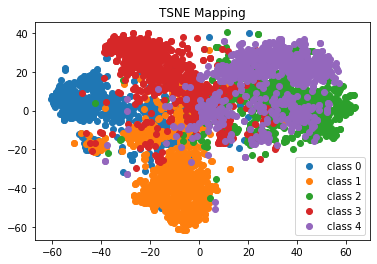

In [ ]:
for i in range(5):
    plt.scatter(embedded[np.where(y_all==i)][:, 0], embedded[np.where(y_all==i)][:, 1], label="class {}".format(i))
plt.legend()
plt.title("TSNE Mapping")
plt.show()

We can observe that there appears to be five clusters wich some outliers. Note that class4 and class 2 are distributed very closely which might be problematic for classification. Besides this, we can conclude that the feature extraction of VGG works fine on the flower dataset.

##### QUESTION 24: Report the best result (in terms of rand score) within the table below. For HDBSCAN introduce your own reasonable grid over min cluster size and min samples.

In [ ]:
from sklearn.base import TransformerMixin

class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        # self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                # X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
kmeans_dl_pred = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit_predict(f_all)
report_five_scores(y_all, kmeans_dl_pred, verbose=True)

homogeneity score is 0.32326649815857034
completeness score is 0.35756485789113185
v measure score is 0.33955175080565714
adjusted rand score is 0.18995737449143266
adjusted mutual info score is 0.33860323498557254


(0.32326649815857034,
 0.35756485789113185,
 0.33955175080565714,
 0.18995737449143266,
 0.33860323498557254)

In [ ]:
agg_dl_pred = AgglomerativeClustering(n_clusters=5).fit_predict(f_all)
report_five_scores(y_all, agg_dl_pred, verbose=True)

homogeneity score is 0.357423727296284
completeness score is 0.41402546658906453
v measure score is 0.3836481433561248
adjusted rand score is 0.18855278251971858
adjusted mutual info score is 0.38274333888130496


(0.357423727296284,
 0.41402546658906453,
 0.3836481433561248,
 0.18855278251971858,
 0.38274333888130496)

In [ ]:
hdb_dl_pred = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1).fit_predict(f_all)
report_five_scores(y_all, hdb_dl_pred, verbose=True)

homogeneity score is 0.01417069688093785
completeness score is 0.04165417899478249
v measure score is 0.021147158326817315
adjusted rand score is 0.015014212771105666
adjusted mutual info score is 0.020072513499417792


(0.01417069688093785,
 0.04165417899478249,
 0.021147158326817315,
 0.015014212771105666,
 0.020072513499417792)

In [ ]:
svd_matrix = TruncatedSVD(n_components=50).fit_transform(f_all)
kmeans_dl_svd_pred = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit_predict(svd_matrix)
report_five_scores(y_all, kmeans_dl_svd_pred, verbose=True)

homogeneity score is 0.3332726050262207
completeness score is 0.3693518485930537
v measure score is 0.35038590563646305
adjusted rand score is 0.19359608931536987
adjusted mutual info score is 0.349452066756806


(0.3332726050262207,
 0.3693518485930537,
 0.35038590563646305,
 0.19359608931536987,
 0.349452066756806)

In [ ]:
umap_metrix = umap.UMAP(n_components=50, metric="cosine").fit_transform(f_all)
kmeans_dl_umap_pred = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit_predict(umap_metrix)
report_five_scores(y_all, kmeans_dl_umap_pred, verbose=True)

homogeneity score is 0.5322796638953332
completeness score is 0.541728785042352
v measure score is 0.5369626578077332
adjusted rand score is 0.4655307686222496
adjusted mutual info score is 0.5363242984608585


(0.5322796638953332,
 0.541728785042352,
 0.5369626578077332,
 0.4655307686222496,
 0.5363242984608585)

In [ ]:
ae_matrix = Autoencoder(50).fit_transform(f_all)
kmeans_dl_ae_pred = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit_predict(ae_matrix)
report_five_scores(y_all, kmeans_dl_ae_pred, verbose=True)

100%|██████████| 100/100 [44:00<00:00, 26.40s/it]


homogeneity score is 0.2751571565065192
completeness score is 0.3239804803410551
v measure score is 0.29757952848133407
adjusted rand score is 0.2518741989835909
adjusted mutual info score is 0.2965399299133352


(0.2751571565065192,
 0.3239804803410551,
 0.29757952848133407,
 0.2518741989835909,
 0.2965399299133352)

In [ ]:
svd_matrix = TruncatedSVD(n_components=50).fit_transform(f_all)
agg_dl_svd_pred = AgglomerativeClustering(n_clusters=5).fit_predict(svd_matrix)
report_five_scores(y_all, agg_dl_svd_pred, verbose=True)

homogeneity score is 0.34751035873165714
completeness score is 0.40495930295734134
v measure score is 0.37404179811462296
adjusted rand score is 0.19457732479599218
adjusted mutual info score is 0.373120305962466


(0.34751035873165714,
 0.40495930295734134,
 0.37404179811462296,
 0.19457732479599218,
 0.373120305962466)

In [ ]:
umap_metrix = umap.UMAP(n_components=50, metric="cosine").fit_transform(f_all)
agg_dl_umap_pred = AgglomerativeClustering(n_clusters=5).fit_predict(umap_metrix)
report_five_scores(y_all, agg_dl_umap_pred, verbose=True)

homogeneity score is 0.49702776847012775
completeness score is 0.5363618110326684
v measure score is 0.5159462013511473
adjusted rand score is 0.43172543196314056
adjusted mutual info score is 0.5152590888436316


(0.49702776847012775,
 0.5363618110326684,
 0.5159462013511473,
 0.43172543196314056,
 0.5152590888436316)

In [ ]:
ae_matrix = Autoencoder(50).fit_transform(f_all)
agg_dl_ae_pred = AgglomerativeClustering(n_clusters=5).fit_predict(ae_matrix)
report_five_scores(y_all, agg_dl_ae_pred, verbose=True)

100%|██████████| 100/100 [57:57<00:00, 34.78s/it]


homogeneity score is 0.29117865452251396
completeness score is 0.33143267898479767
v measure score is 0.3100043842374173
adjusted rand score is 0.18776917326218362
adjusted mutual info score is 0.30899973176179174


(0.29117865452251396,
 0.33143267898479767,
 0.3100043842374173,
 0.18776917326218362,
 0.30899973176179174)

In [ ]:
min_cluster_size_list = [100, 110, 120, 130, 140, 150, 160, 170, 180]
min_sample_size_list = [10, 20, 30, 40, 50, 60]
hbd_score_svd = []
hbd_hyper_param = []

for min_cluster in min_cluster_size_list:
    for min_sample in min_sample_size_list:
        print(min_cluster, min_sample) 
        svd_matrix = TruncatedSVD(n_components=50).fit_transform(f_all)                        
        hbd_hyper_param.append([min_cluster, min_sample])
        hdb_dl_svd_pred = hdbscan.HDBSCAN(min_cluster_size=min_cluster, min_samples=min_sample).fit_predict(svd_matrix)
        hbd_score_svd.append(report_five_scores(y_all, hdb_dl_svd_pred, verbose=False))

# svd_matrix = TruncatedSVD(n_components=50).fit_transform(f_all)
# hdb_dl_svd_pred = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1).fit_predict(svd_matrix)
# report_five_scores(y_all, hdb_dl_svd_pred, verbose=True)

10 10
10 20
10 30
10 40
10 50
10 60
20 10
20 20
20 30
20 40
20 50
20 60
30 10
30 20
30 30
30 40
30 50
30 60
40 10
40 20
40 30
40 40
40 50
40 60
50 10
50 20
50 30
50 40
50 50
50 60
60 10
60 20
60 30
60 40
60 50
60 60
70 10
70 20
70 30
70 40
70 50
70 60


In [ ]:
hbd_score_umap = []

for min_cluster in min_cluster_size_list:
    for min_sample in min_sample_size_list:   
        print(min_cluster, min_sample)  
        umap_metrix = umap.UMAP(n_components=50, metric="cosine").fit_transform(f_all)                       
        hdb_dl_umap_pred = hdbscan.HDBSCAN(min_cluster_size=min_cluster, min_samples=min_sample).fit_predict(umap_metrix)
        hbd_score_umap.append(report_five_scores(y_all, hdb_dl_umap_pred, verbose=False))


10 10
10 20
10 30
10 40
10 50
10 60
20 10
20 20
20 30
20 40
20 50
20 60
30 10
30 20
30 30
30 40
30 50
30 60
40 10
40 20
40 30
40 40
40 50
40 60
50 10
50 20
50 30
50 40
50 50
50 60
60 10
60 20
60 30
60 40
60 50
60 60
70 10
70 20
70 30
70 40
70 50
70 60


In [ ]:
hbd_score_ae = []
ae_matrix = Autoencoder(50).fit_transform(f_all)

for min_cluster in min_cluster_size_list:
    for min_sample in min_sample_size_list:
        print(min_cluster, min_sample)
        hdb_dl_ae_pred = hdbscan.HDBSCAN(min_cluster_size=min_cluster, min_samples=min_sample).fit_predict(ae_matrix)
        hbd_score_ae.append(report_five_scores(y_all, hdb_dl_ae_pred, verbose=False))

100%|██████████| 100/100 [55:55<00:00, 33.56s/it]


10 10
10 20
10 30
10 40
10 50
10 60
20 10
20 20
20 30
20 40
20 50
20 60
30 10
30 20
30 30
30 40
30 50
30 60
40 10
40 20
40 30
40 40
40 50
40 60
50 10
50 20
50 30
50 40
50 50
50 60
60 10
60 20
60 30
60 40
60 50
60 60
70 10
70 20
70 30
70 40
70 50
70 60


In [ ]:
printResults([], [], hbd_score_umap, [], hbd_hyper_param, "HDBSCAN", True, [], True)
# print(hbd_score_umap)

HDBSCAN UMAP Component 50, Best min cluster size is:  40  Best min sample size is:  40
UMAP Best Homogeneity:  0.17971479481663133
UMAP Best Completeness:  0.6361792885161124
UMAP Best V measure:  0.2802590008625824
UMAP Best Adjusted Rand Index:  0.0953565808444732
UMAP Best Adjusted Mutual Info Score:  0.2798758753108453
---------------------------------------------------------------------------------------------------------


In [ ]:
printResults(hbd_score_svd, [], [], [], hbd_hyper_param, "HDBSCAN", True, [], True)

HDBSCAN SVD Component 50, Best min cluster size is:  10  Best min sample size is:  10
SVD Best Homogeneity:  1.3876720518042915e-16
SVD Best Completeness:  1.0
SVD Best V measure:  2.7753441036085825e-16
SVD Best Adjusted Rand Index:  0.0
SVD Best Adjusted Mutual Info Score:  5.0062065300172974e-17
---------------------------------------------------------------------------------------------------------


In [ ]:
printResults([], [], [], hbd_score_ae, hbd_hyper_param, "HDBSCAN", True, [], True)

HDBSCAN Autoencoder num_feature = 50, Best min cluster size is:  10  Best min sample size is:  10
autoencoder Best Homogeneity:  1.3876720518042915e-16
autoencoder Best Completeness:  1.0
autoencoder Best V measure:  2.7753441036085825e-16
autoencoder Best Adjusted Rand Index:  0.0
autoencoder Best Adjusted Mutual Info Score:  5.0062065300172974e-17
---------------------------------------------------------------------------------------------------------


From our experiments, we can observe that the best result in terms of random score would be the combination of UMAP as dim reduction and Kmeans as clustering technique. The adjusted rand score we got is 0.4655307686222496, which is the highest among all the other combinations.

### Question 25

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                output = self.forward(X_)
                loss = criterion(output, y_)
                
                loss.backward()
                optimizer.step()
                
        return self
    
    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        
        accuracy = None
        match_count, total_count = 0, 0
        dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128)
        for (X, y) in dataloader:
            soft_probs = self.forward(X)
            match_count += torch.sum(torch.argmax(soft_probs, dim=1) == y)
            total_count += len(X)
        return match_count / total_count

In [ ]:
from sklearn.model_selection import train_test_split
import random

np.random.seed(42)
random.seed(42)

train_data, test_data, train_label, test_label = train_test_split(f_all, y_all, test_size=0.2)

In [ ]:
mlp = MLP(4096)
_ = mlp.train(train_data, train_label)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.24it/s]


In [ ]:
print(mlp.eval(test_data, test_label))

tensor(0.9101, device='cuda:0')


In [ ]:
svd = TruncatedSVD(n_components=100).fit(train_data)
reduced_train_data = svd.transform(train_data)
reduced_test_data = svd.transform(test_data)

In [ ]:
mlp_reduced = MLP(100)
_ = mlp_reduced.train(reduced_train_data, train_label)

ERROR! Session/line number was not unique in database. History logging moved to new session 551


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.50it/s]


In [ ]:
print(mlp_reduced.eval(reduced_test_data, test_label))

tensor(0.8965, device='cuda:0')


As shown above, the test accuracy of MLP classifier on the original VGG features is 0.91 while the reduced-dim features on the MLP classifier have 0.8965 accuracy. The performance does suffer with the dimension reduction, but not significantly. Compared to the result of question 24, where the reduced-dimension feature has the best performance, we can see there is a discrepency. We reason that this might be because for clustering, especially for kmeans, if the feature space is high dimensional then clustering algorithms will have trouble distinguishing the distance between vectors due to curse of dimensionality. On the other hand, for a neural network, high dimensional feature space is not a big problem and some times even bigger dimension carries more information.